# **GloVe**

GloVe = **Global Vectors for Word Representation**

It’s a word-embedding method like Word2Vec, but it focuses on **global co-occurrence patterns** across the whole corpus instead of only predicting next words.

**Idea:**
Words that appear in similar contexts → have similar vectors.

But unlike Word2Vec, GloVe doesn’t train using prediction.
It **factorizes a co-occurrence matrix**.


### ✅ Why GloVe Exists 

Word2Vec looks at *local* windows only.
But some meanings require *global* statistics.

Example:
*ice* and *steam* both co-occur with *water*, but *ice* co-occurs more with *cold* and *steam* more with *hot*.

GloVe uses these global ratios to learn meaning.


### ✅ How GloVe Works

### Step 1: Build a **co-occurrence matrix**

For each word pair (i, j), count how often word j appears near word i in a window (example window size = 5).

Example:

```
Vocabulary - [ king queen man apple ]
```
co-occurrence matrix:

|       | king | queen | man | apple |
| ----- | ---- | ----- | --- | ----- |
| king  | 0    | 15    | 20  | 0     |
| queen | 15   | 0     | 5   | 0     |
| man   | 20   | 5     | 0   | 0     |
| apple | 0    | 0     | 0   | 0     |


### Step 2: Learn vectors so that:

```
dot(word_vector_i, word_vector_j) ≈ log(co-occurrence count)
```

But GloVe adds:

* **weighting** (to avoid exploding gradients)
* **bias values** for each word

This leads to a clean optimization objective.

### Step 3: After training, we use:

```
final_vector = word_vector + context_vector
```

---

### ✅ What GloVe Produces

A dictionary like:

```
"king": [0.14, -0.82, ...]   (50D or 100D or 300D vector)
"queen": [0.22, -0.78, ...]
```

---

### ✅Key Features

| Feature                | Meaning                                 |
| ---------------------- | --------------------------------------- |
| **Global training**    | Looks at whole corpus, not just windows |
| **Faster**             | Uses matrix factorization tricks        |
| **Stable**             | Good embeddings on small/medium corpora |
| **Semantic analogies** | king − man + woman ≈ queen              |

---

### ✅When to Use GloVe

* When you want **ready-made embeddings**
* When you want good **semantic quality**
* When training data is limited

---

### ✅Pretrained GloVe Versions

Most used sizes:

* **50d**
* **100d**
* **200d**
* **300d**

Corpora:

* Wikipedia + Gigaword (6B)
* Common Crawl (42B, 840B)

---



# 🧪  Python Code: Load GloVe

### Step 1 — Download `glove.6B.100d.txt` 

Search on Google - GloVe: Global Vectors for Word Representation

[here i used](https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.50d.zip) 

### Step 2 — Load embeddings

In [ ]:
import numpy as np

# Function to load GloVe-style word vectors from a text file
def load_vectors(file_path, dim=50):
    embeddings = {}  # dictionary to store word -> vector

    with open(file_path, "r", encoding="utf8") as f:
        for line in f:
            parts = line.rstrip().split()  # split each line into word + numbers

            # Each line should have 1 word + `dim` numbers
            if len(parts) != dim + 1:
                continue  # skip lines that don't match expected format

            word = parts[0]  # first item is the word

            try:
                # convert remaining items to a NumPy array of floats
                vector = np.asarray(parts[1:], dtype="float32")
            except:
                continue  # skip lines that contain invalid numbers

            embeddings[word] = vector  # store word and its vector in dictionary

    return embeddings

# Load GloVe vectors from file
glove = load_vectors(
    "wiki_giga_2024_50_MFT20_vectors_seed_123_alpha_0.75_eta_0.075_combined.txt",
    dim=50
)

# Print basic info
print("Loaded words:", len(glove))         # how many words were loaded
print("Vector shape:", glove["king"].shape)  # size of each word vector (50D)


Loaded words: 1287614
Vector shape: (50,)


In [ ]:
# Get Vector of a Word
glove["king"]

array([-0.39003 ,  0.868335,  0.684807, -0.758227,  1.54142 , -2.006612,
       -0.107967,  1.26053 ,  0.259971, -0.587266,  1.167608,  0.216386,
        0.712985, -0.514837, -0.531705, -0.250713,  0.272562,  0.420457,
        0.422036,  0.27177 ,  0.284001,  0.207707, -1.011175,  0.179848,
        0.022646,  0.190826,  0.031093, -0.066455, -1.041256, -0.207106,
       -0.603441, -0.189004,  0.666082,  0.122189, -0.373318,  0.543726,
       -0.258834,  3.978247,  0.525289,  0.927056, -0.609059, -0.553423,
       -0.297424,  0.271807,  0.41184 , -0.055333, -0.55883 , -0.065188,
        1.167179,  0.132492], dtype=float32)

In [ ]:
# Compute Similarity Between Words**

from numpy.linalg import norm

def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (norm(v1) * norm(v2)) # cos(angle between 2 vectors)

print(cosine_similarity(glove["king"], glove["queen"]))
print(cosine_similarity(glove["king"], glove["banana"]))

0.809598
0.3098249


In [7]:
# Check Most Similar Words**

def most_similar(query, embeddings, top_n=10):
    query_vec = embeddings[query]
    sims = {}
    for word, vec in embeddings.items():
        sims[word] = cosine_similarity(query_vec, vec)
    return sorted(sims.items(), key=lambda x: x[1], reverse=True)[1:top_n+1]

most_similar("computer", glove)

[('computers', 0.9283039),
 ('software', 0.90775603),
 ('technology', 0.87725294),
 ('digital', 0.84384745),
 ('internet', 0.8437318),
 ('machines', 0.8371099),
 ('pc', 0.8298869),
 ('electronic', 0.8272066),
 ('computing', 0.82667863),
 ('applications', 0.8253656)]

In [12]:
# Word Analogy (king − man + woman = ?)

def find_analogy(a, b, c, embeddings, top_n=10):
    target_vec = embeddings[b] - embeddings[a] + embeddings[c]
    
    scores = {}
    for word, vec in embeddings.items():
        if word in [a, b, c]:
            continue  # remove input words
        scores[word] = cosine_similarity(target_vec, vec)
    
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]


print(find_analogy("man", "king", "woman", glove))

[('queen', 0.8715486), ('daughter', 0.8064808), ('throne', 0.78520334), ('eldest', 0.7805679), ('elizabeth', 0.7787424), ('mother', 0.77159065), ('princess', 0.76935375), ('father', 0.76844066), ('marriage', 0.76663), ('wife', 0.7637212)]


## t-SNE Visualization

Using perplexity: 30


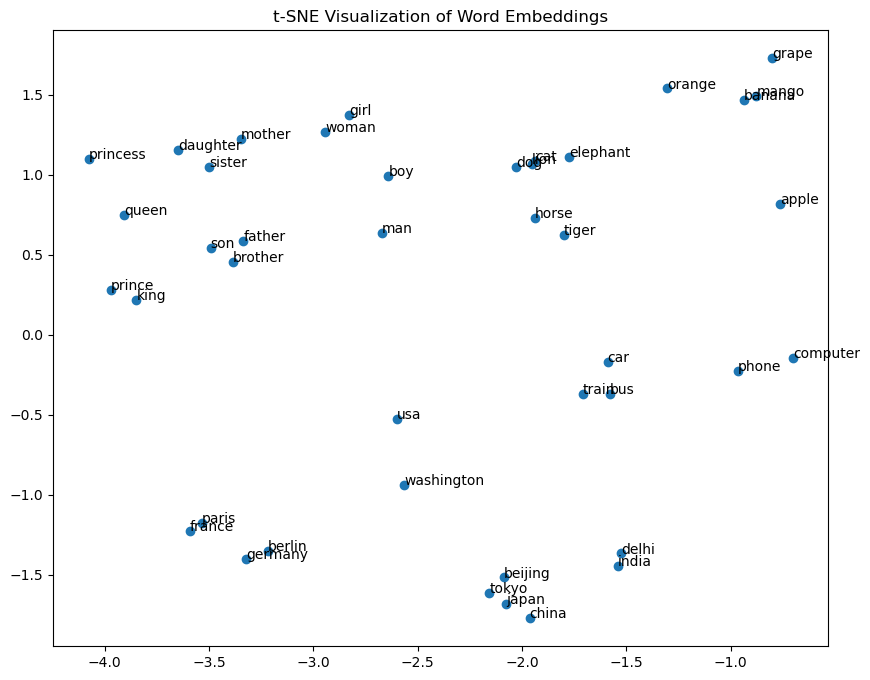

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# your words
words = [ 
    "king", "queen", "prince", "princess", "man", "woman", "boy", "girl",
    "father", "mother", "son", "daughter", "brother", "sister",
    "india", "china", "japan", "france", "germany", "usa",
    "delhi", "beijing", "tokyo", "paris", "berlin", "washington",
    "cat", "dog", "tiger", "lion", "elephant", "horse",
    "apple", "banana", "mango", "orange", "grape",
    "car", "bus", "train", "phone", "computer"   ]


# filter available words
valid_words = [w for w in words if w in glove]

vectors = np.array([glove[w] for w in valid_words])

# ----- auto perplexity -----
perplexity = max(5, min(30, len(valid_words) - 1))
print("Using perplexity:", perplexity)

# ----- t-SNE -----
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
points = tsne.fit_transform(vectors)

# ----- plot -----
plt.figure(figsize=(10, 8))
plt.scatter(points[:, 0], points[:, 1])

for i, word in enumerate(valid_words):
    plt.annotate(word, (points[i, 0], points[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()


### ✅Difference: Word2Vec vs GloVe 

| Word2Vec                  | GloVe                           |
| ------------------------- | ------------------------------- |
| Predicts context using NN | Factorizes co-occurrence matrix |
| Local information         | Global information              |
| Slow on large corpora     | Faster, scalable                |
| Can be trained easily     | Harder to train from scratch    |

---

### ✅ Summary

* GloVe = global co-occurrence + matrix factorization
* Produces strong semantic embeddings
* Pretrained models widely used
* Easy to load and use
* Supports analogies and similarity tasks

---

